# Chuẩn bị


1. Tải Stockfish từ trang chính thức: https://stockfishchess.org/download/

2. Sau khi tải về, đổi tên file `.exe` thành `stockfish`

3. Di chuyển file này vào thư mục: `chess-bot/.venv/bin/`

4. Tải dataset từ https://www.kaggle.com/code/gabrielhaselhurst/chess-dataset/input

5. Di chuyển file này vào thư mục chess-bot

## Import thu vien can thiet

In [16]:
from stockfish import Stockfish
import numpy as np
import matplotlib.pyplot as plt
import chess
import random
from typing import List
from evaluation.static_evaluation import evaluate_board
import pandas as pd
import chess.svg
import cairosvg
import io
from PIL import Image
import math


## Config duong dan

In [17]:
stockfish_path = ".venv/bin/stockfish"
# stockfish_path = ".venv/Scripts/stockfish.exe"

## Stockfish Engine

In [18]:
stockfish = Stockfish(stockfish_path)
stockfish.set_skill_level(20)
stockfish.set_depth(20)

In [19]:
def get_stockfish_score(fen: str) -> float:
    stockfish.set_fen_position(fen)
    score = stockfish.get_evaluation()
    return score["value"] if score["type"] == "cp" else (1000 if score["value"] > 0 else -1000)

## Lay tap du lieu 

In [20]:
df = pd.read_csv('chessData.csv')
df.head()

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [21]:
test_fens = df.sample(n=100, random_state=42)['FEN'].to_list()
stockfish_scores = (
    df.sample(n=100, random_state=42)['Evaluation']
    .astype(str)
    .str.replace("+", "", regex=False)  # Remove "+"
    .str.extract(r'([-]?\d+)')[0]       # Extract numbers (returns DataFrame, select column 0)
    .astype(float)
    .fillna(0)
    .astype(int)
    .tolist()  # Convert to Python list
)

print(stockfish_scores)
print(sum(stockfish_scores))

[-35, -201, 121, 280, 328, 74, -26, 43, -1285, 296, -360, 1087, -806, 0, 243, -252, 680, 784, -4795, 20, -72, -159, -78, 53, 492, 47, -319, 42, 78, 85, -128, 682, -22, 746, 5454, 0, 440, -240, 76, 53, -19, -50, -533, -779, 0, 388, -139, 3, 523, 2238, -374, -49, 0, -337, 78, -88, 470, 94, 100, 119, -322, 124, 0, -17, -153, 703, -59, 71, 73, 72, -70, 45, 0, 246, 13, 161, -66, -6934, -61, -54, -26, -338, 0, 155, 173, 384, -433, 0, 192, -27, -50, -13, 365, 0, -101, 175, 125, 6061, 76, 64]
5625


## Visualization

In [22]:
def fen_to_image(fen):
    board = chess.Board(fen)
    svg_code = chess.svg.board(board, size=250)
    png_data = cairosvg.svg2png(bytestring=svg_code)
    return Image.open(io.BytesIO(png_data))

def showHorizontally(fens, boards_per_row=5):
    total_boards = len(fens)
    rows = math.ceil(total_boards / boards_per_row)  # Calculate required rows

    fig, axes = plt.subplots(rows, boards_per_row, figsize=(boards_per_row * 3, rows * 3))

    # Ensure axes is always a 2D array (for consistency)
    if rows == 1:
        axes = np.array([axes])  # Convert to 2D array if only one row
    if boards_per_row == 1:
        axes = np.array([[ax] for ax in axes])  # Convert to 2D array if only one column

    for i, fen in enumerate(fens):
        row = i // boards_per_row
        col = i % boards_per_row

        image = fen_to_image(fen)  # Convert FEN to PIL Image
        image_array = np.array(image)  # Convert PIL Image to NumPy array

        axes[row, col].imshow(image_array)
        axes[row, col].axis('off')

    # Hide empty subplots (if any)
    for i in range(total_boards, rows * boards_per_row):
        fig.delaxes(axes.flatten()[i])  

    plt.tight_layout()
    plt.show()

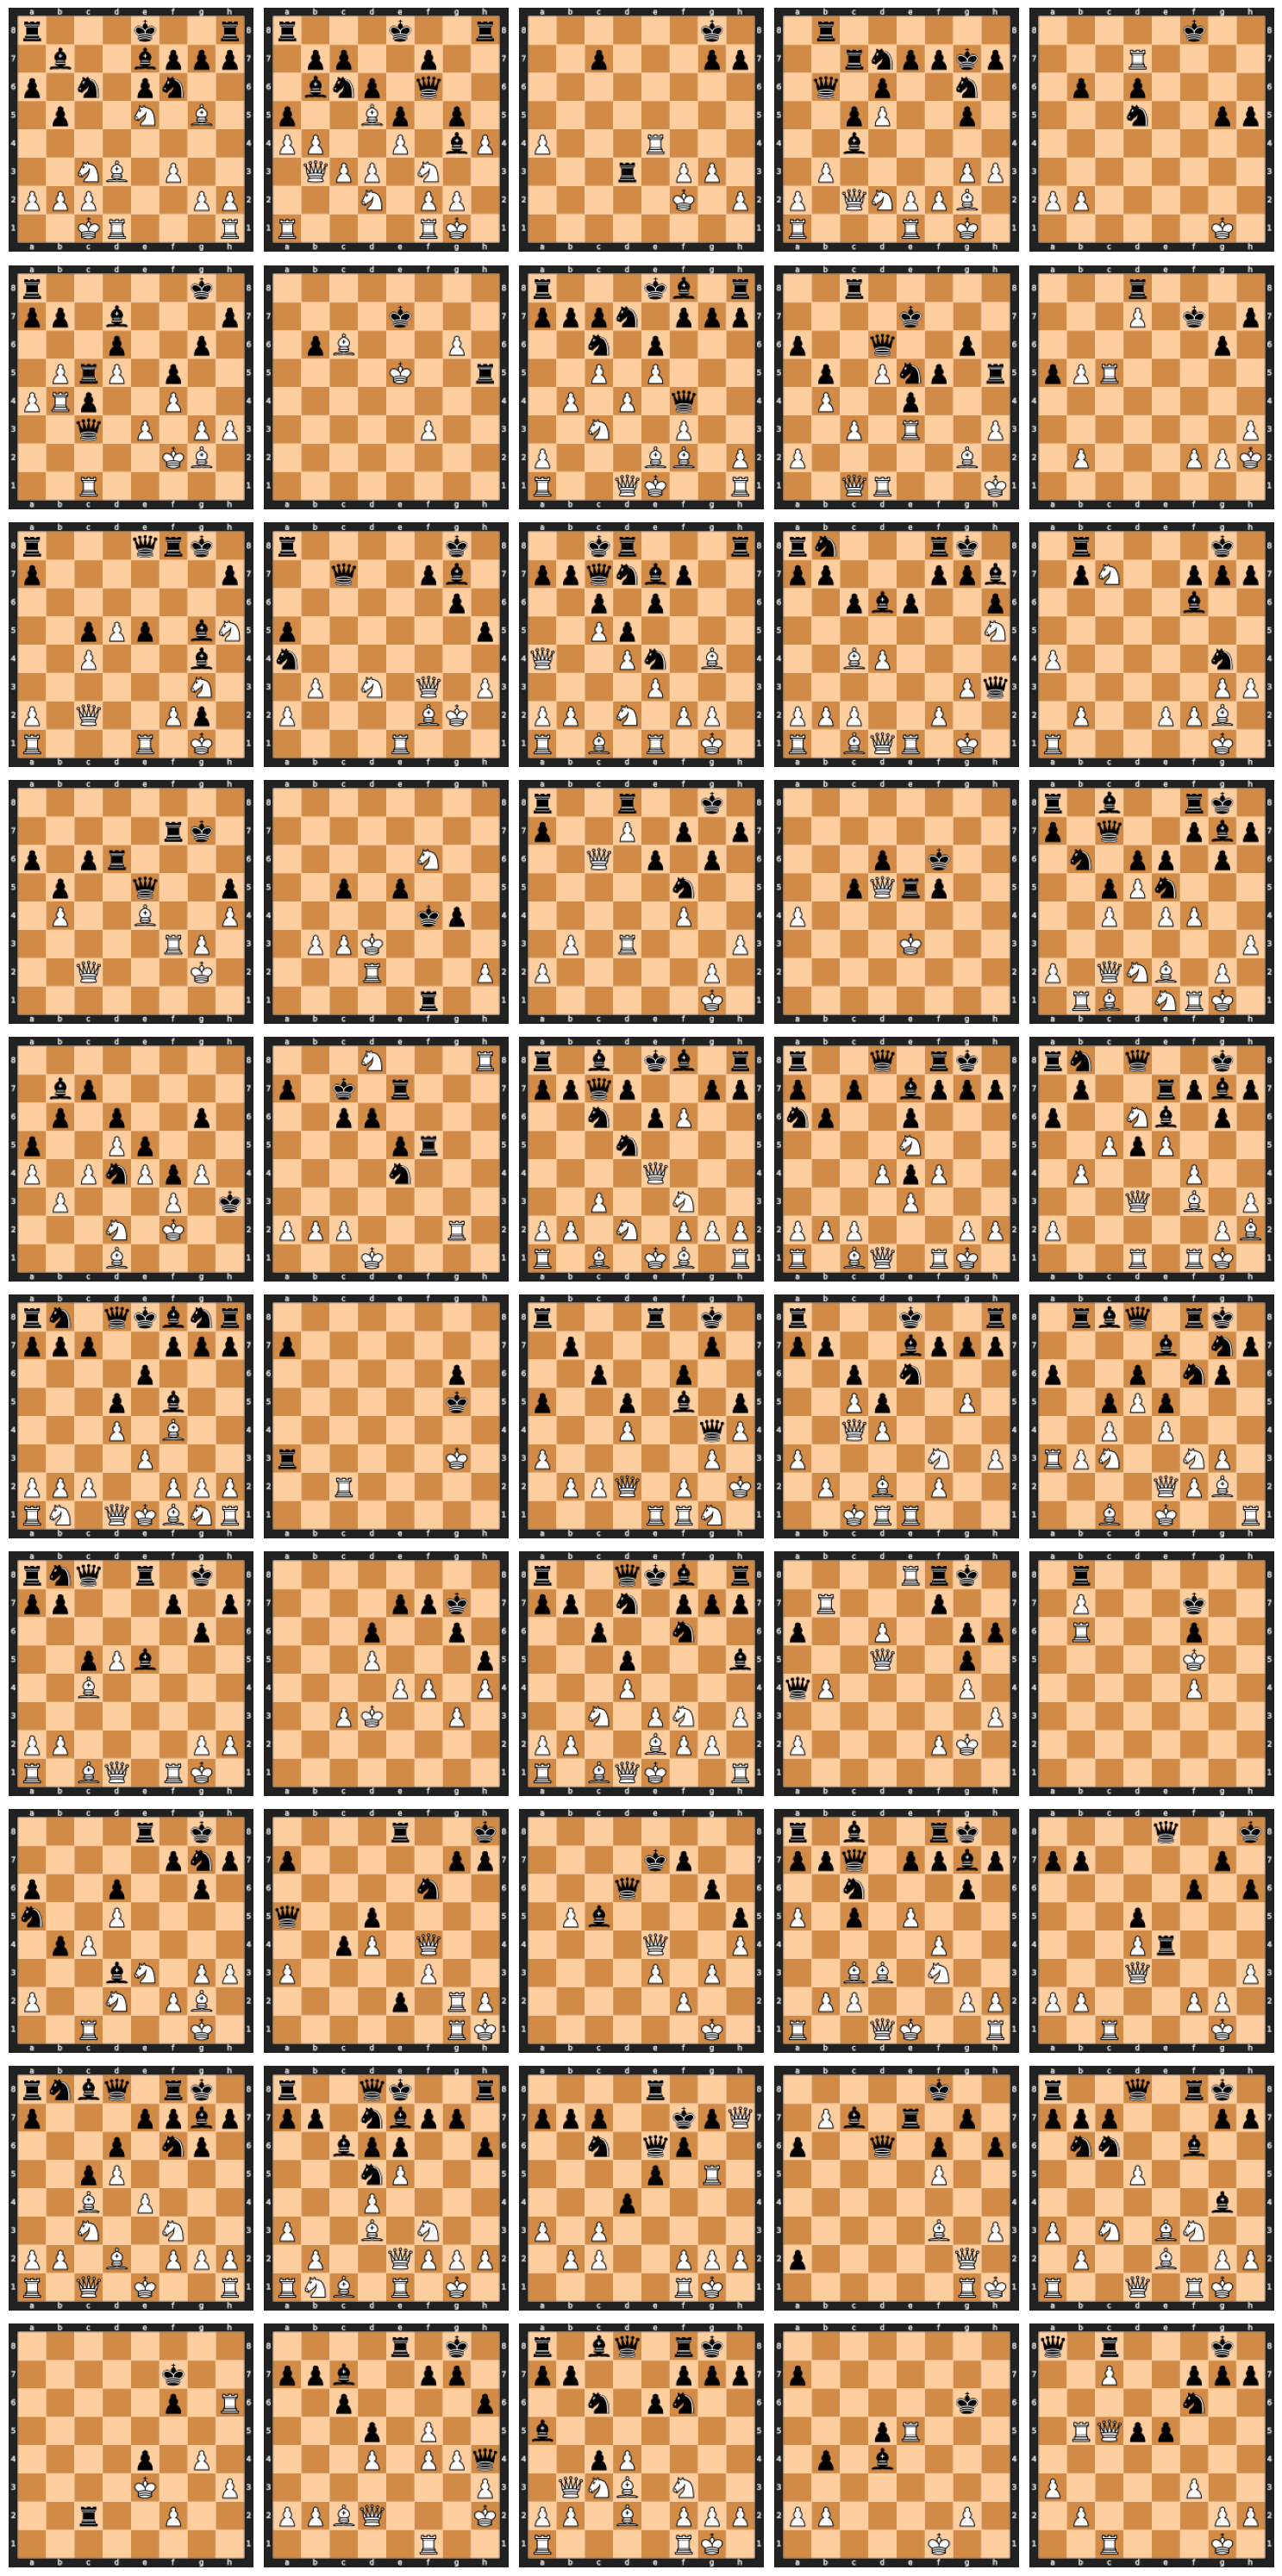

In [23]:
showHorizontally(df.sample(n=50, random_state=42)['FEN'])

# 1. Initialization

In [24]:
def initialize_population(size: int):
    """
    Initialize a population with chess-specific value ranges.

    Args:
        size (int): Number of individuals in the population.

    Returns:
        np.ndarray: Population matrix (size, num_params) with meaningful bounds.
    """
    # Define bounds for each gene type
    bounds = np.array([
        [-5, 5],   # Evaluation Weight: Material
        [-5, 5],   # Evaluation Weight: King Safety
        [-5, 5],   # Evaluation Weight: Pawn Structure
        [-5, 5],   # Evaluation Weight: Mobility
        [-5, 5],   # Evaluation Weight: Center Control
        [80, 120],   # Pawn Value
        [270, 350],  # Knight Value
        [300, 350],  # Bishop Value
        [450, 550],  # Rook Value
        [850, 1050], # Queen Value
        [9000, 12000], # King Value
        [0, 30],  # Doubled Pawn Penalty
        [0, 30],  # Isolated Pawn Penalty
        [0, 50],   # King Safety Multiplier
        [0, 10],   # Mobility Multiplier
        [0, 20]    # Center Control Multiplier
    ])

    # Generate random values within bounds
    low, high = bounds[:, 0], bounds[:, 1]
    population = np.random.uniform(low=low, high=high, size=(size, len(bounds)))

    return population

print(initialize_population(200))

[[ 0.468249   -2.70714052 -0.07709766 ... 43.01823243  9.74338293
  12.33593582]
 [-2.33584813  1.59782668 -4.99466294 ... 44.519676    8.70181176
   1.50651079]
 [-2.52090365 -4.95766089 -4.01383347 ... 39.11827483  6.6522683
  12.855632  ]
 ...
 [ 4.32421062 -3.65754922 -2.22447062 ...  4.84329509  4.83041505
  14.09111217]
 [ 2.79368926  4.45093322 -4.71147775 ... 47.03185731  2.11236499
   4.80224388]
 [-4.94344503  4.14752767 -3.06694295 ...  4.5256046   6.33795315
  10.25857305]]


# Fitness function

In [25]:
def fitness_function(weights: List[float]) -> float:
    total_error = 0
    for fen, sf_score in zip(test_fens, stockfish_scores):
        eval_score = evaluate_board(fen, weights)
        total_error += abs(eval_score - sf_score)
    return -total_error  # Càng gần giá trị của Stockfish thì fitness càng cao

# Selection

In [26]:
def tournament_selection(population, fitness_scores, tournament_size=5):
    """
    Selects a parent using tournament selection.

    Args:
        population (np.array): Population of individuals.
        fitness_scores (np.array): Fitness scores of individuals.
        tournament_size (int): Number of individuals in the tournament.

    Returns:
        np.array: Selected individual.
    """
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    best_index = selected_indices[np.argmax(fitness_scores[selected_indices])]
    return population[best_index]

# Crossover

In [27]:
def crossover_blx_alpha(parent1, parent2, alpha=0.4):
    """
    Perform BLX-α crossover to blend weights from two parents.
    
    Args:
        parent1 (np.array): First parent weights.
        parent2 (np.array): Second parent weights.
        alpha (float): Exploration parameter (0.0 - 0.5 recommended).

    Returns:
        np.array: Child weights.
    """
    p1, p2 = np.array(parent1), np.array(parent2)
    min_vals = np.minimum(p1, p2)
    max_vals = np.maximum(p1, p2)
    range_vals = max_vals - min_vals
    
    # Generate offspring within blended range
    child = min_vals - alpha * range_vals + np.random.rand(len(p1)) * (1 + 2 * alpha) * range_vals
    return np.clip(child, -1, 1)  # Keep values in range

# Mutation

In [28]:
def mutate_gaussian(individual, mutation_rate=0.3, mutation_strength=0.1):
    """
    Apply Gaussian mutation to perturb weights slightly.

    Args:
        individual (np.array): Weights of an individual.
        mutation_rate (float): Probability of each weight mutating.
        mutation_strength (float): Standard deviation of Gaussian noise.

    Returns:
        np.array: Mutated weights.
    """
    mutation_mask = np.random.rand(len(individual)) < mutation_rate
    mutation_values = np.random.normal(0, mutation_strength, size=len(individual))
    individual[mutation_mask] += mutation_values[mutation_mask]
    return np.clip(individual, -1, 1)  # Keep values in range

In [33]:
def adaptive_mutation_rate(generation, total_generations, min_rate=0.05, max_rate=0.3):
    """
    Decreases mutation rate over generations to balance exploration and exploitation.
    """
    return max_rate - (max_rate - min_rate) * (generation / total_generations)

In [34]:
def adaptive_mutation_strength(generation, total_generations, min_strength=0.01, max_strength=0.2):
    """
    Decreases mutation strength over generations.
    """
    return max_strength - (max_strength - min_strength) * (generation / total_generations)

# GA

In [35]:
import numpy as np

def genetic_algorithm(
    fitness_function, 
    population_size=50, 
    generations=200, 
    elite_size=10, 
    tournament_size=5, 
    convergence_threshold=20  # Stop if no improvement for X generations
):
    """
    Runs an optimized Genetic Algorithm with early stopping when convergence is detected.

    Args:
        fitness_function (function): Function to evaluate individuals.
        population_size (int): Number of individuals in the population.
        generations (int): Max number of generations.
        elite_size (int): Number of top individuals to retain.
        mutation_rate (float): Probability of mutation.
        mutation_strength (float): Mutation intensity.
        tournament_size (int): Tournament selection group size.
        convergence_threshold (int): Stop early if best fitness does not improve for this many generations.

    Returns:
        np.ndarray: Best found individual.
        list: Fitness score history.
    """
    # Initialize population with random genes
    population = initialize_population(population_size)
    best_fitness_history = []
    best_fitness = -np.inf  # Store best fitness found
    no_improvement_count = 0  # Track stagnation

    for generation in range(generations):
        # Evaluate fitness for all individuals
        fitness_scores = np.array([fitness_function(ind) for ind in population])
        mutation_rate = adaptive_mutation_rate(generation, generations)
        mutation_strength = adaptive_mutation_strength(generation, generations)


        # Sort and keep top elite individuals
        sorted_indices = np.argsort(fitness_scores)[::-1]  # Sort descending
        elite = population[sorted_indices[:elite_size]]

        # Track best fitness
        current_best_fitness = fitness_scores[sorted_indices[0]]
        best_fitness_history.append(current_best_fitness)

        # Check if fitness improved
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            no_improvement_count = 0  # Reset stagnation counter
        else:
            no_improvement_count += 1  # Increment stagnation counter

        # Stop early if fitness has not improved in `convergence_threshold` generations
        if no_improvement_count >= convergence_threshold:
            print(f"✅ Converged after {generation+1} generations! Stopping early.")
            break

        # Generate new population
        new_population = []
        for _ in range(population_size - elite_size):
            p1 = tournament_selection(population, fitness_scores, tournament_size)
            p2 = tournament_selection(population, fitness_scores, tournament_size)
            child = crossover_blx_alpha(p1, p2)
            child = mutate_gaussian(child, mutation_rate, mutation_strength)
            new_population.append(child)

        # Create next generation
        population = np.vstack((elite, new_population))

        print(f"Generation {generation+1}: Best Fitness = {current_best_fitness:.3f}")

    return population[0], best_fitness_history


# Tuning

Generation 1: Best Fitness = -43110.672
Generation 2: Best Fitness = -43110.672
Generation 3: Best Fitness = -43110.672
Generation 4: Best Fitness = -43110.672
Generation 5: Best Fitness = -43110.672
✅ Converged after 6 generations! Stopping early.


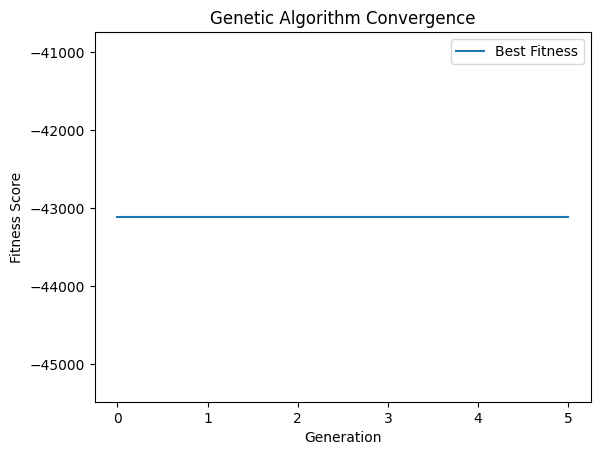

Optimized Weights: [ 4.03377015e-01 -3.03529674e+00  4.51962460e+00  2.66021078e-01
  2.16957899e+00  1.08156502e+02  3.07602511e+02  3.02677448e+02
  5.11135350e+02  9.40434795e+02  1.07455563e+04  9.80262603e+00
  1.52911975e+01  4.43281419e+01  3.48797705e-01  9.97655706e+00]
Suggested weights fitness: -47341.5


In [39]:
best_weights, best_fitness_history = genetic_algorithm(fitness_function, population_size=50, generations=50, convergence_threshold=5)

# Plot Convergence Graph
plt.plot(best_fitness_history, label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("Genetic Algorithm Convergence")
plt.legend()
plt.show()

print("Optimized Weights:", best_weights)

chromosomes = [
                1.0, 0.8, -1.2, 0.7, 1.15,
                100, 300, 320, 500, 900, 10000,
                10, 10,
                20,
                5,
                10
            ]
print("Suggested weights fitness:", fitness_function(chromosomes))